# Ensemble Failure Prediction Notebook

**Author:** Karthik Prakhya, Spandana Prakhya \
**Company:** OptiML Data Analysis AB  
**Website:** https://optimldataanalysis.se  
**Contact:** info@optimldataanalysis.se    

**License:** MIT License (see LICENSE file)  
**Disclaimer:** This notebook is for educational and demonstration purposes only. All data used are synthetic or publicly available; no confidential or client-specific information is included.

---

## Executive Summary

This notebook is a demonstration of methods used in an AI/ML & optimization problem. It uses synthetic or public datasets and is intended to illustrate methodology, not to present results from client engagements.

**Key objectives:**
- Demonstrate approach and pipeline
- Provide a reproducible example for technical reviewers
- Highlight business impact where appropriate

**Tools Used:** Python, NumPy, pandas, matplotlib, and standard optimization/ML libraries (e.g., OR-Tools, Gurobi, scikit-learn, TensorFlow/PyTorch).


# Ensemble Machine Learning for Failure Prediction
### Combining LSTM (temporal deep learning) and Gradient Boosted Trees  
### With Mock Azure IoT Integration


## 1. Introduction

We will explore an **ensemble approach** that blends deep learning (LSTM) with gradient boosting (LightGBM) for **failure prediction** using time-series sensor data.

The key idea is to model temporal dependencies using an LSTM network while capturing aggregated feature-level patterns with a LightGBM model. These are combined via a **stacking ensemble** with a logistic regression meta-model.

---

### Mathematical motivation
Let $x_{t}^{(i)} \in \mathbb{R}^{d}$ be the sensor readings of unit $i$ at time $t$, and let $y_t^{(i)} \in \{0,1\}$ denote whether a failure occurs (or is imminent) at time $t$.

Our goal is to learn a function

$$ f: (x_{t-w+1}, \dots, x_t) \mapsto \hat{y}_t $$

that predicts the probability of failure in the near future, where $w$ is the sequence window length. This notebook demonstrates **horizon-based failure prediction** using the
NASA Turbofan Engine Degradation (C-MAPSS) dataset. The data can be considered to be from a fleet of engines of the same type with different degrees of initial wear and manufacturing variation that is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data along with noisy data from 26 different sensors. The goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.

We will:
- Load data using **kagglehub**
- Predict **failure within next H cycles**
- Train:
  - **LSTM** on raw sensor sequences
  - **LightGBM** on rolling statistics
- **Stack** both models
- Visualize degradation and model performance

In [16]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


## 2. Load NASA C-MAPSS dataset

The dataset $N$ units, each producing multivariate time series with $d$ sensor measurements and operational settings over $T$ timesteps. A small proportion of units experience a **failure event**, which we expect to lead to some increase in sensor drift before the event.

We denote the dataset as:
$$ \mathcal{D} = \{ (x_t^{(i)}, y_t^{(i)}) \}_{i=1,t=1}^{N,T} $$ with $x_t^{(i)} \in \mathbb{R}^d$ and $y_t^{(i)} \in \{0, 1\}$.

In [17]:

path = kagglehub.dataset_download("behrad3d/nasa-cmaps")
train_file = path + "/CMaps/train_FD001.txt"
cols = ['unit','cycle'] + [f'op_{i}' for i in range(1,4)] + [f'sensor_{i}' for i in range(1,22)]
df = pd.read_csv(train_file, sep=' ', header=None)
df = df.iloc[:, :len(cols)]
df.columns = cols
df.head()


,unit,cycle,op_1,op_2,op_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 3. Compute Remaining Useful Life (RUL) and Horizon Labels

Remaining Useful Life (RUL) for unit $u$ at cycle $t$:

$$RUL_t^{(u)} = T_u - t$$

Horizon-based label for early warning:

$$y_t^{(u)} = \begin{cases} 1 & \text{if } RUL_t^{(u)} \le H \\ 0 & \text{otherwise} \end{cases}$$

In [18]:
max_cycles = df.groupby('unit')['cycle'].max()
df['RUL'] = df.apply(lambda r: max_cycles[r['unit']] - r['cycle'], axis=1)

H = 30  # horizon
df['label'] = (df['RUL'] <= H).astype(int)

df[['unit','cycle','RUL','label']].head()


,unit,cycle,RUL,label
0,1,1,191.0,0
1,1,2,190.0,0
2,1,3,189.0,0
3,1,4,188.0,0
4,1,5,187.0,0



## 4. Exploratory Visualization


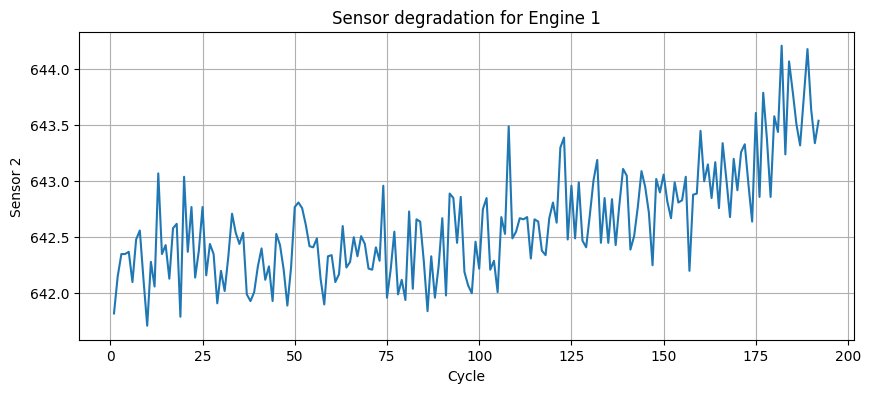

In [19]:

# Sensor degradation example
unit_id = 1
plt.figure(figsize=(10,4))
plt.plot(df[df.unit==unit_id]['cycle'], df[df.unit==unit_id]['sensor_2'])
plt.xlabel('Cycle')
plt.ylabel('Sensor 2')
plt.title('Sensor degradation for Engine 1')
plt.grid()
plt.show()


## 5. Create LSTM Windows and LightGBM Rolling Features

LSTM input sequences:
 
$$X_{seq} = [x_{t-SEQ\_LEN+1}, ..., x_t] \in \mathbb{R}^{SEQ\_LEN \times d}$$

Aggregated statistics per window:

$$X_{agg} = [\mu, \sigma, x_{t}, x_t - x_{t-SEQ\_LEN+1}]$$

where $\mu$ and $\sigma$ are mean and standard deviation over the window.

In [20]:

SEQ_LEN = 30
SENSORS = [c for c in df.columns if c.startswith('sensor_')]

X_seq, X_agg, y, units = [], [], [], []

for uid, g in df.groupby('unit'):
    g = g.sort_values('cycle')
    arr = g[SENSORS].values
    labels = g['label'].values
    for i in range(SEQ_LEN-1, len(g)):
        win = arr[i-SEQ_LEN+1:i+1]
        X_seq.append(win)
        mean = win.mean(0)
        std = win.std(0)
        slope = win[-1] - win[0]
        X_agg.append(np.concatenate([mean,std,slope]))
        y.append(labels[i])
        units.append(uid)

X_seq = np.array(X_seq)
X_agg = np.array(X_agg)
y = np.array(y)
units = np.array(units)

print(X_seq.shape, X_agg.shape, y.mean())


(17731, 30, 21) (17731, 63) 0.17483503468501493



## 6. Train / Validation Split by Engine

Train/validation split avoids leakage by ensuring engines do not cross sets.


In [21]:

train_units, val_units = train_test_split(np.unique(units), test_size=0.2, random_state=42)

train_mask = np.isin(units, train_units)

X_seq_tr, X_seq_va = X_seq[train_mask], X_seq[~train_mask]
X_agg_tr, X_agg_va = X_agg[train_mask], X_agg[~train_mask]
y_tr, y_va = y[train_mask], y[~train_mask]

sc_seq = StandardScaler().fit(X_seq_tr.reshape(-1, X_seq_tr.shape[-1]))
sc_agg = StandardScaler().fit(X_agg_tr)

X_seq_tr = sc_seq.transform(X_seq_tr.reshape(-1, X_seq_tr.shape[-1])).reshape(X_seq_tr.shape)
X_seq_va = sc_seq.transform(X_seq_va.reshape(-1, X_seq_va.shape[-1])).reshape(X_seq_va.shape)
X_agg_tr = sc_agg.transform(X_agg_tr)
X_agg_va = sc_agg.transform(X_agg_va)



## 7. LSTM Model (Detailed Formalism)

We model sequences using a Long Short-Term Memory (LSTM) network. For a single time step within the LSTM cell, the update equations (one layer) are:

$$
\begin{aligned}
i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \quad\text{(input gate)}\\
f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \quad\text{(forget gate)}\\
o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \quad\text{(output gate)}\\
\tilde{c}_t &= \tanh(W_c x_t + U_c h_{t-1} + b_c)\quad\text{(cell candidate)}\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \quad\text{(cell state)}\\
h_t &= o_t \odot \tanh(c_t) \quad\text{(hidden state)}
\end{aligned}
$$

The model outputs a probability via a sigmoid layer on the final hidden state $h_T$:

$$
\hat{p} = \sigma(w^\top h_T + b).
$$

We optimize the binary cross-entropy loss over the dataset:

$$
\mathcal{L}_{\text{BCE}} = -\frac{1}{N}\sum_{i=1}^N \left[ y^{(i)}\log \hat{p}^{(i)} + (1-y^{(i)})\log(1-\hat{p}^{(i)})\right].
$$

Regularization such as dropout and early stopping are used to prevent overfitting.


In [22]:

def build_lstm():
    inp = layers.Input((SEQ_LEN, X_seq_tr.shape[-1]))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.LSTM(32)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

lstm = build_lstm()
lstm.fit(X_seq_tr, y_tr, epochs=15, batch_size=256,
         validation_data=(X_seq_va, y_va),
         callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

p_lstm = lstm.predict(X_seq_va).ravel()
print('LSTM ROC-AUC:', roc_auc_score(y_va, p_lstm))


Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - AUC: 0.9369 - loss: 0.2897 - val_AUC: 0.9881 - val_loss: 0.1269
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9913 - loss: 0.0965 - val_AUC: 0.9929 - val_loss: 0.0913
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9956 - loss: 0.0679 - val_AUC: 0.9914 - val_loss: 0.0934
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9968 - loss: 0.0578 - val_AUC: 0.9914 - val_loss: 0.0961
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9971 - loss: 0.0547 - val_AUC: 0.9943 - val_loss: 0.0702
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - AUC: 0.9981 - loss: 0.0436 - val_AUC: 0.9939 - val_loss: 0.0747
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - AUC: 0.9985 - loss: 0.0390 - val_AUC: 0.9942 - val_loss: 0.0803
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - AUC: 0.9984 - loss: 0.0405 - val_AUC: 0.9895 - val_loss: 0.0864
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM ROC-AUC: 0.9949741


## 8. Gradient Boosted Trees (LightGBM) — Formal Details

Gradient boosting builds an additive model of $M$ decision trees. Let $F_0(x)$ be an initial prediction (e.g. log-odds). At iteration $m$ we add a tree $h_m(x)$ with learning rate $\nu$:

$$
F_m(x) = F_{m-1}(x) + \nu\, h_m(x).
$$

For binary logistic loss, given true label $y\in\{0,1\}$ and prediction $p=\sigma(F(x))$, the per-sample loss is:

$$
\ell(y, F) = -y\log \sigma(F) - (1-y)\log(1-\sigma(F)).
$$

Gradient boosting fits $h_m(x)$ to the negative gradient (pseudo-residuals):

$$
r_i^{(m)} = -\left.\frac{\partial \ell(y_i, F(x_i))}{\partial F(x_i)}\right|_{F=F_{m-1}} = y_i - \sigma(F_{m-1}(x_i)).
$$

LightGBM uses histogram-based splitting and leaf-wise growth with constraints to efficiently approximate the functional gradient steps. Some of the key features of LightGBM include the following:

- *Leaf-wise tree growth*: Unlike other algorithms that grow trees level-by-level, LightGBM grows trees leaf-by-leaf, which can lead to faster convergence and lower loss.
- *Exclusive Feature Bundling (EFB)*: It bundles mutually exclusive features to reduce the number of features without significantly hurting accuracy.
- *Histogram-based method*: It bins continuous feature values into discrete bins, which makes finding the best split faster.
- *Gradient-based One Side Sampling (GOSS)*: This technique focuses on data points with larger gradients, while randomly sampling a subset of data points with smaller gradients to reduce the number of data points used for training without affecting accuracy. 

When training a GBM model, one may need to choose between XGBoost, LightGBM or CatBoost. Below is a comparison of the two algorithms:
# Comparison of LightGBM vs. XGBoost vs. CatBoost

| Aspect | LightGBM | XGBoost | CatBoost |
|--------|-----------|----------|-----------|
| **Tree Growth Strategy** | **Leaf-wise (best-first)**; fast convergence but can overfit | **Level-wise**; balanced trees, slower but stable | **Symmetric (oblivious) trees**; highly regularized and stable |
| **Split Finding Method** | Histogram-based with feature binning | Histogram-based (varies by config) | Uses ordered boosting + oblivious splits |
| **Handling Categorical Features** | Native support (category-based split); better than XGBoost but less robust than CatBoost | No native support; requires one-hot or external encoding | **Best categorical handling**; built-in encoding (target-based + ordered boosting) prevents leakage |
| **Dealing With High-Dimensional Sparse Data** | **EFB (Exclusive Feature Bundling)** reduces dimensionality | Handles sparse data well but no bundling | Not designed for extremely sparse high-dimensional data (slower than LightGBM) |
| **Sampling Strategy** | **GOSS** (keeps large-gradient samples) | Uniform row/column sampling (like Random Forest) | No special sampling; relies on ordered boosting for stability |
| **Speed** | Usually **fastest**, especially on large or sparse datasets | Fast but often slower than LightGBM | Generally slower than both on large datasets but efficient for categorical-heavy data |
| **Memory Usage** | Typically **lowest** due to bundling + binning | Higher than LightGBM | Moderate; higher than LGBM but lower than many alternatives |
| **Accuracy** | Often highest on large datasets or complex patterns | Very strong accuracy; consistent | Often **SOTA for categorical datasets**; very stable accuracy |
| **Overfitting Risk** | Higher without tuning (deep leaf-wise trees) | Lower by default | Very low due to symmetric trees + ordered boosting |
| **Ease of Tuning** | Requires careful tuning (num_leaves, depth) | Well-understood tuning but many parameters | Easiest: generally performs well with minimal tuning |
| **GPU Support** | Very fast GPU implementation | Strong GPU support but sometimes slower than LGBM | GPU support good but not the fastest |
| **Handling Imbalanced Data** | Good with leaf-wise splits | Good with built-in scale_pos_weight | Good but less specialized |
| **Interpretability** | Least interpretable (unbalanced deep trees) | More interpretable | Highly interpretable due to symmetric trees |
| **Best Use Cases** | Large-scale, high-dimensional, sparse data | Broad general-purpose boosting | **Datasets with many categorical features**; small-to-medium tabular datasets |

For this example, we use LightGBM as real failure prediction over a horizon from sensor data can often be large, high-dimensional, sparse and have significant class imbalance.

In [10]:

dtrain = lgb.Dataset(X_agg_tr, label=y_tr)
dval = lgb.Dataset(X_agg_va, label=y_va, reference=dtrain)

params = {'objective':'binary','metric':'auc','learning_rate':0.05,'num_leaves':31}

gbm = lgb.train(params, dtrain, 300,
                valid_sets=[dval],
                callbacks=[lgb.early_stopping(30)])

p_gbm = gbm.predict(X_agg_va, num_iteration=gbm.best_iteration)
print('GBM ROC-AUC:', roc_auc_score(y_va, p_gbm))


[LightGBM] [Info] Number of positive: 2480, number of negative: 11761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9896
[LightGBM] [Info] Number of data points in the train set: 14241, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174145 -> initscore=-1.556530
[LightGBM] [Info] Start training from score -1.556530
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[265]	valid_0's auc: 0.994971
GBM ROC-AUC: 0.9949707766662921



## 9. Stacking Ensemble — Formal Derivation

Let base model outputs be $p_1(x)$ (LSTM) and $p_2(x)$ (GBM). We construct a meta-feature vector:

$$
z(x) = [p_1(x),\; p_2(x)]^\top.
$$

The logistic regression meta-model computes:

$$
\hat{p}(x) = \sigma(w^\top z(x) + b).
$$

Estimating $w$ maximizes the log-likelihood (or equivalently minimizes cross-entropy). Using regularization (e.g., $L_2$) yields the penalized objective:

$$
\min_{w,b} -\sum_{i=1}^N \left[y_i\log \hat{p}_i + (1-y_i)\log(1-\hat{p}_i)\right] + \lambda \|w\|_2^2.
$$

Remarks:
- It is critical that base model predictions for training the meta-model are obtained via out-of-fold predictions (to avoid stacking leakage). In this example we used the train set predictions directly for simplicity; for production you should use cross-validated out-of-fold predictions.

In [11]:

X_stack_tr = np.vstack([lstm.predict(X_seq_tr).ravel(),
                         gbm.predict(X_agg_tr)]).T
X_stack_va = np.vstack([p_lstm, p_gbm]).T

meta = LogisticRegression(class_weight='balanced')
meta.fit(X_stack_tr, y_tr)

p_stack = meta.predict_proba(X_stack_va)[:,1]
print('STACK ROC-AUC:', roc_auc_score(y_va, p_stack))


446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
STACK ROC-AUC: 0.99551646622457



## 10. Evaluation Metrics (Formal Definitions)

**ROC AUC:** Area under the Receiver Operating Characteristic curve. For a score function $s(x)$, ROC plots TPR vs FPR as threshold varies. AUC is:

$$
\text{AUC} = \int_0^1 \text{TPR}(\alpha)\, d\text{FPR}(\alpha).
$$

**Average Precision (AP):** The area under the Precision-Recall curve:

$$
\text{AP} = \int_0^1 \text{Precision}(r)\, dr,
$$

which is more informative in imbalanced settings.

**Calibration:** For probabilities $\hat{p}$, calibration can be done by grouping predictions into bins and comparing $\mathbb{E}[y|\hat{p}\in\text{bin}]$ against the mean $\hat{p}$ in the bin.



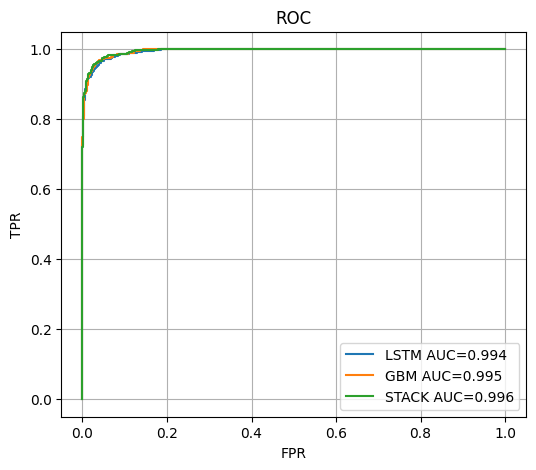

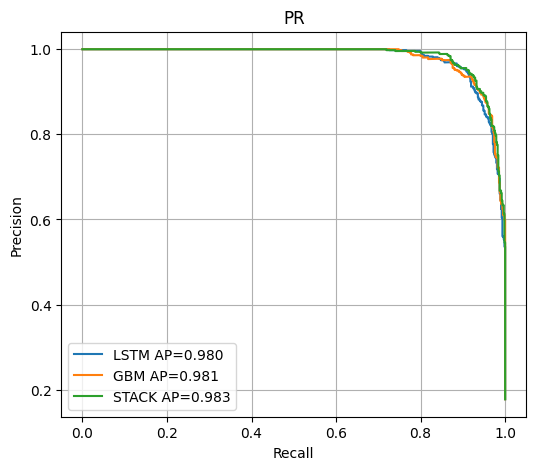

In [15]:

def plot_curve(y, preds, names, kind='roc'):
    plt.figure(figsize=(6,5))
    for p,n in zip(preds,names):
        if kind=='roc':
            fpr,tpr,_ = roc_curve(y,p)
            plt.plot(fpr,tpr,label=f'{n} AUC={roc_auc_score(y,p):.3f}')
        else:
            prec,rec,_ = precision_recall_curve(y,p)
            plt.plot(rec,prec,label=f'{n} AP={average_precision_score(y,p):.3f}')
    plt.legend(); plt.grid()
    plt.xlabel('Recall' if kind!='roc' else 'FPR')
    plt.ylabel('Precision' if kind!='roc' else 'TPR')
    plt.title(kind.upper())
    plt.show()

plot_curve(y_va,[p_lstm,p_gbm,p_stack],['LSTM','GBM','STACK'],'roc')
plot_curve(y_va,[p_lstm,p_gbm,p_stack],['LSTM','GBM','STACK'],'pr')
